In [1]:
import urllib.parse
import time
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hmac
import hashlib
import base64
from plotly import figure_factory
from datetime import datetime
from dataclasses import dataclass
# import talib

# Support Data Classes


@dataclass
class Intervals:
    minute = 1
    fiveMin = 5
    fifteenMin = 15
    halfHour = 30
    hour = 60
    fourHours = 240
    day = 1440
    week = 10080
    halfMonth = 21600


@dataclass
class OrderTypes:
    market = "market"
    limit = "limit"
    stop_loss = "stop-loss"
    take_profit = "take-profit"
    stop_loss_limit = "stop-loss-limit"
    take_profit_limit = "take-profit-limit"
    settle_position = "settle-position"


@dataclass
class Type:
    buy = 'buy'
    sell = 'sell'

# UNIX TIME is from January 1st, 1970


@dataclass
class Months:
    january: int = 1
    february: int = 2
    march: int = 3
    april: int = 4
    may: int = 5
    june: int = 6
    july: int = 7
    august: int = 8
    september: int = 9
    october: int = 10
    november: int = 11
    december: int = 12

# Get Trades


@dataclass
class Intervals:
    minute = 1
    fiveMin = 5
    fifteenMin = 15
    halfHour = 30
    hour = 60
    fourHours = 240
    day = 1440
    week = 10080
    halfMonth = 21600


# KRAKEN API

In [2]:
def timeStampToTime(unixtime: int) -> str:
    # print(time.ctime(unixtime))
    # return time.ctime(unixtime)
    return time.strftime("%H:%M", time.gmtime(unixtime))


def timeStampToDateTime(unixtime: int) -> datetime:
    # print(time.ctime(unixtime))
    # return time.ctime(unixtime)
    return datetime.fromtimestamp(unixtime)


def timeToTimeStamp(year: int, month: Months, day: int, hour: int, minute: int, second: int) -> int:
    return int(datetime.timestamp(datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)))


def curentTime() -> None:
    resp = requests.get('https://api.kraken.com/0/public/Time')
    print(resp.json())


In [29]:
def getOfflinePrices(interval=Intervals.fifteenMin, since = timeToTimeStamp(2017, 1, 1, 1, 0, 0), pair='XBTEUR') -> pd.DataFrame:
    file = '../data/{}_{}.csv'.format(pair, interval)

    df = pd.read_csv(file)
    df.columns = ['time', 'open', 'high', 'low', 'close', 'volume', 'count']

    for column in df.columns:
        df[column] = pd.to_numeric(df[column])

    dateTimeData = [timeStampToDateTime(data) for data in df.time]
    df["dateTime"] = dateTimeData
    df = df.set_index(df.dateTime)

    return df.loc[df['time'] > since]


def nTimesLargerInterval(data: pd.DataFrame, interval: int = 3) -> pd.DataFrame:
    dataArr = []

    index = 0
    for row in range(data.time.count()):
        if data.time[row] % 3600 == 0:
            index = row
            break

    for row in range(index, data.time.count(), interval):
        firstRow = row
        lastRow = (row + interval - 1) if (row + interval - 1) < data.time.count() else (data.time.count() - 1)

        dataArr.append([
            data.time[firstRow],
            data.open[firstRow],
            max(data.high[_row] for _row in range(row, lastRow + 1)),
            -max((-data.low[_row]) for _row in range(row, lastRow + 1)),
            data.close[lastRow],
            # np.median([data.vwap[_row] for _row in range(row, lastRow + 1)]),
            sum(data.volume[_row] for _row in range(row, lastRow + 1)),
            sum(data['count'][_row] for _row in range(row, lastRow + 1)),
            data.dateTime[firstRow]
        ])

    tmpDf = pd.DataFrame(list(map(np.ravel, dataArr)), columns=data.columns)
    tmpDf.index = tmpDf.dateTime
    return tmpDf


# SMA

In [4]:
# EMA = alpha * data[x] + (1 - alpha) * EMA[1], where alpha = 2 / (days[y] + 1)
def _get_sma(data, length) -> int:
    return sum(data[:length]) / length


def get_sma(data: pd.DataFrame, length):
    noneIndeces = data.size-data.count()
    our_range = range(len(data))[noneIndeces + length - 1:]

    sma = [np.mean(data[i - length + 1: i + 1]) for i in our_range]
    return np.array([None for _ in range((length+noneIndeces)-1)] + sma)


def get_DF_sma(data: pd.DataFrame, length) -> pd.DataFrame:
    noneIndeces = data.size-data.count()
    our_range = range(len(data))[noneIndeces + length - 1:]

    sma = [np.mean(data[i - length + 1: i + 1]) for i in our_range]
    sma = np.array([None for _ in range((length+noneIndeces)-1)] + sma)
    return pd.DataFrame(sma, index=data.index.copy(), columns=['data'])


# EMA

In [5]:
def get_ema(data: pd.DataFrame, length, smoothing=2, com=None) -> list[int]:
    noneIndeces = data.size-data.count()
    ema = [None for _ in range((length+noneIndeces)-1)]
    ema.append(_get_sma(data[noneIndeces:], length))

    alpha = (smoothing / (1 + length))
    if com:
        alpha = 1/(com)

    for price in data[length+noneIndeces:]:
        ema.append((price * alpha) + ema[-1] * (1 - alpha))
    return ema


def get_DF_ema(data: pd.DataFrame, length, smoothing=2, com=None) -> pd.DataFrame:
    noneIndeces = data.size-data.count()
    ema = [None for _ in range((length+noneIndeces)-1)]
    ema.append(_get_sma(data[noneIndeces:], length))

    alpha = (smoothing / (1 + length))
    if com:
        alpha = 1/(com)

    for price in data[length+noneIndeces:]:
        ema.append((price * alpha) + ema[-1] * (1 - alpha))

    return pd.DataFrame(ema, index=data.index.copy(), columns=['data'])


# MACD

In [6]:
def get_macd(data, fastperiod=12, slowperiod=26, signalperiod=9) -> list[pd.DataFrame, pd.DataFrame]:
    fastEma = pd.DataFrame(get_ema(data, fastperiod), index=data.index.copy(), columns=['data'])
    slowEma = pd.DataFrame(get_ema(data, slowperiod), index=data.index.copy(), columns=['data'])

    macd = fastEma - slowEma

    macdsignal = pd.DataFrame(get_ema(macd.data, signalperiod), index=data.index.copy(), columns=['data'])
    return (macd, macdsignal)

@dataclass
class PriceStates:
    hold = 'hold'
    rising = 'rising'
    falling = 'falling'
    risingPullBack = 'risingPullBack'
    fallingPullBack = 'fallingPullBack'

def get_macd_divergence(signal,prices) -> None:
    extreme = {'low':0,'high':0}

    # priceStates = {'rising': False,'falling': False}
    priceState = PriceStates.hold

    for (index,price) in enumerate(prices[1:]):
        if price > prices[index]:
            # extreme['high'] = price

            if priceState == PriceStates.falling:
                priceState = PriceStates.rising
                # check divergence
        if price < prices[index]:
            # extreme['low'] = price

            if priceState == PriceStates.rising:
                priceState = PriceStates.falling


# HMA

In [7]:
def get_hma(data: pd.DataFrame, length) -> list[int]:
    noneIndeces = data.size-data.count()

    sma1 = get_DF_sma(data[noneIndeces:], length)
    sma2 = get_DF_sma(data[noneIndeces:], int(length/2))
    sma_diff = 2 * sma2 - sma1

    return get_DF_sma(sma_diff.data, int(np.sqrt(length)))


# RSI

In [8]:
# def get_rsi(df, lenght = 14, ema = True):
#     """
#     Returns a pd.Series with the relative strength index.
#     """
#     close_delta = df['close'].diff()
#     # Make two series: one for lower closes and one for higher closes

#     up = pd.DataFrame(close_delta.clip(lower=0))
#     down = pd.DataFrame(-1 * close_delta.clip(upper=0).replace(-0,0))

#     if ema is True:
# 	    # Use exponential moving average
#         ma_up = numpy_ewma_vectorized(up.close,lenght,com = lenght - 1)
#         ma_down = numpy_ewma_vectorized(down.close,lenght,com = lenght - 1)
#     else:
#         # Use simple moving average
#         ma_up = get_DF_sma(up,lenght)
#         ma_down = get_DF_sma(down,lenght)

#     rsi = abs(ma_up / ma_down)
#     rsi = 100 - (100/(1 + rsi))
#     return rsi,ma_up,ma_down

def get_rsi2(df, lenght=14, ema=True):
    """
    Returns a pd.Series with the relative strength index.
    """
    close_delta = df['close'].diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)

    if ema is True:
        # Use exponential moving average
        ma_up = up.ewm(com=lenght - 1, min_periods=lenght).mean()
        ma_down = down.ewm(com=lenght - 1, min_periods=lenght).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window=lenght, adjust=False).mean()
        ma_down = down.rolling(window=lenght, adjust=False).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi, ma_up, ma_down


# Plots and Tests

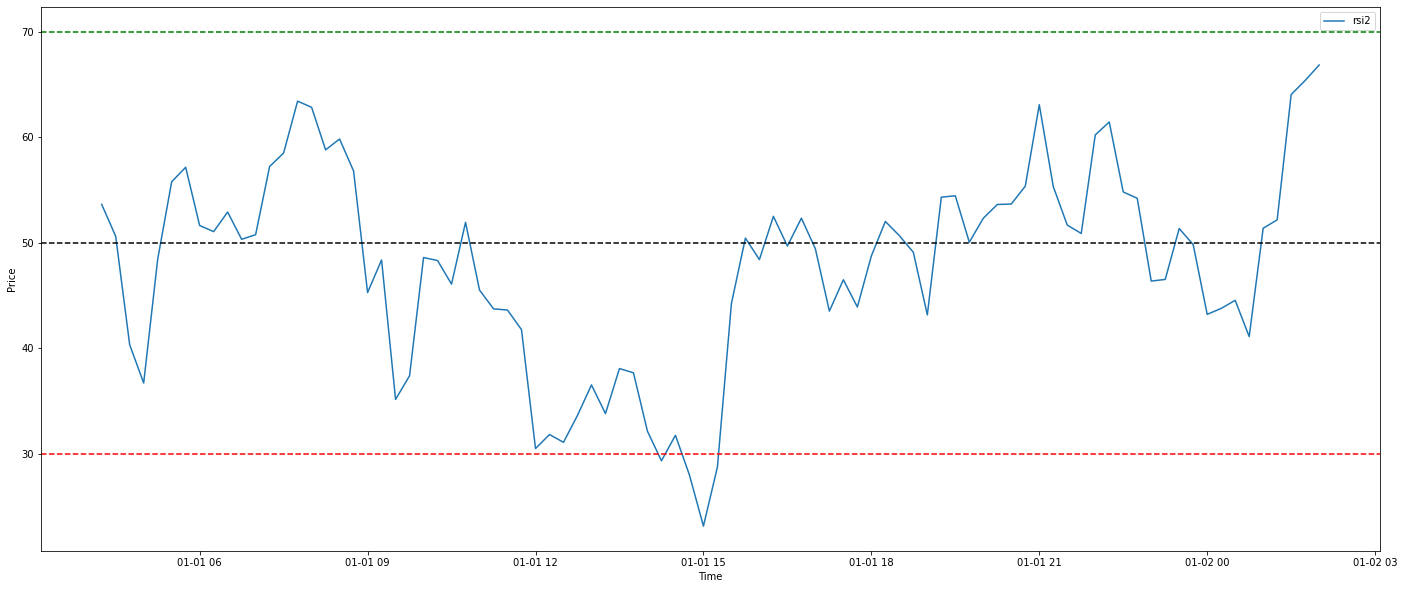

In [10]:
df = getOfflinePrices(interval=Intervals.fifteenMin)

# rsi1,up1,down1 = get_rsi(df,lenght=12)
rsi2, up2, down2 = get_rsi2(df, lenght=12)
# rsi1.loc['2021-09-15 04:00:00']
plt.figure(figsize=[24, 10])
plt.xlabel('Time')
plt.ylabel('Price')
# plt.plot(rsi1[:100], label='rsi1')
plt.plot(rsi2[:100], label='rsi2')
plt.axhline(y=50, color='black', linestyle='--')
plt.axhline(y=70, color='green', linestyle='--')
plt.axhline(y=30, color='red', linestyle='--')
# plt.plot(macdsignal, label='signal')
# plt.plot(np.arange(250-15, df.shape[0]+1),df2.close.tail(16),label='5min')
plt.legend()
plt.show()


In [13]:
# Fifteen minute candlestick plot
fifteenMinDF = getOfflinePrices().tail(30)
fig = figure_factory.create_candlestick(fifteenMinDF.open, fifteenMinDF.high, fifteenMinDF.low, fifteenMinDF.close, dates=fifteenMinDF.dateTime)
fig.show()


In [34]:
df = nTimesLargerInterval(getOfflinePrices(since=timeToTimeStamp(2022,Months.march,30,0,0,0)),interval=2)
fig = figure_factory.create_candlestick(df.open, df.high, df.low, df.close, dates=df.dateTime)
fig.show()


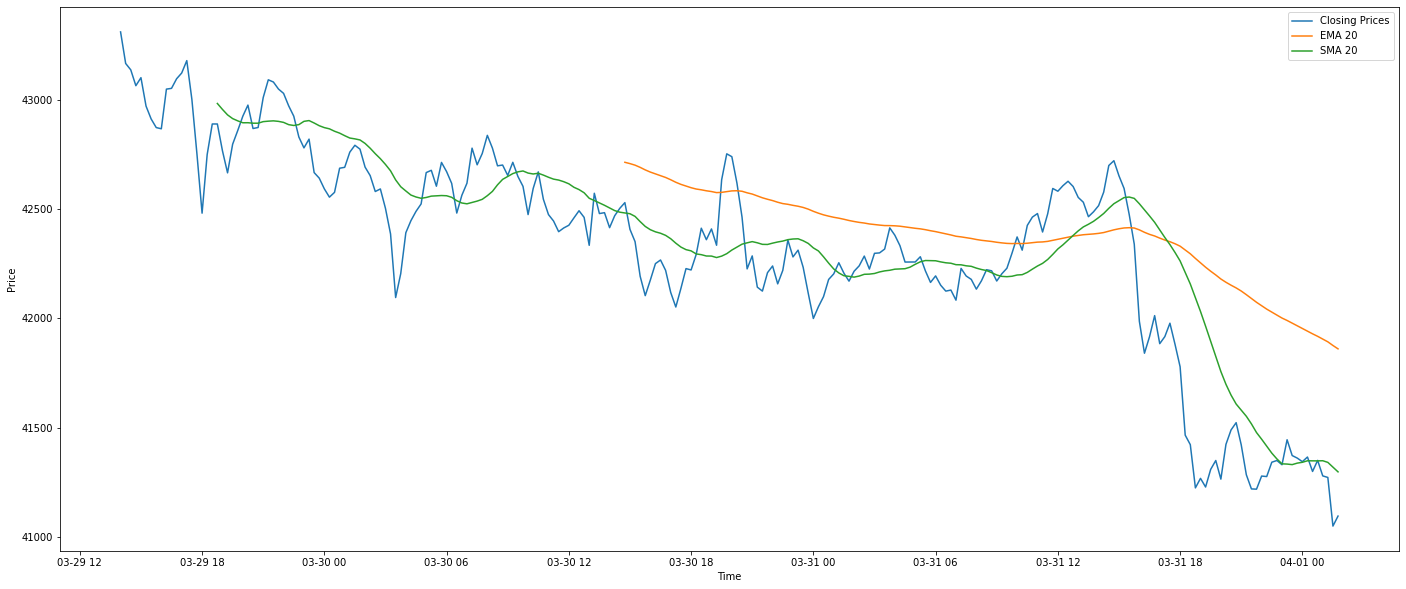

In [24]:
df = getOfflinePrices(interval=Intervals.fifteenMin).tail(240)
# df = nTimesLargerInterval(getOfflinePrices(interval=Intervals.minute, since=timeToTimeStamp(2021, Months.september, 4, 14, 0, 0)))
ema20 = pd.DataFrame(get_ema(df['close'], 100), index=df.index.copy(), columns=['data'])
sma20 = pd.DataFrame(get_sma(df['close'], 20), index=df.index.copy(), columns=['data'])
# ema50 = pd.DataFrame(get_ema(df['close'], 50),index=df.index.copy(),columns=['data'])
# sma50 = pd.DataFrame(get_sma(df['close'], 50),index=df.index.copy(),columns=['data'])
# ema200 = pd.DataFrame(get_ema(df['close'], 200),index=df.index.copy(),columns=['data'])
# sma200 = pd.DataFrame(get_sma(df['close'], 200),index=df.index.copy(),columns=['data'])

plt.figure(figsize=[24, 10])
plt.xlabel('Time')
plt.ylabel('Price')
plt.plot(df['close'], label='Closing Prices')
plt.plot(ema20, label='EMA 20')
plt.plot(sma20, label='SMA 20')
# plt.plot(ema50, label='EMA 50')
# plt.plot(sma50, label='SMA 50')
# plt.plot(ema200, label='EMA 200')
# plt.plot(sma200, label='SMA 200')
# plt.plot(np.arange(250-15, df.shape[0]+1),df2.close.tail(16),label='5min')
plt.legend()
plt.show()


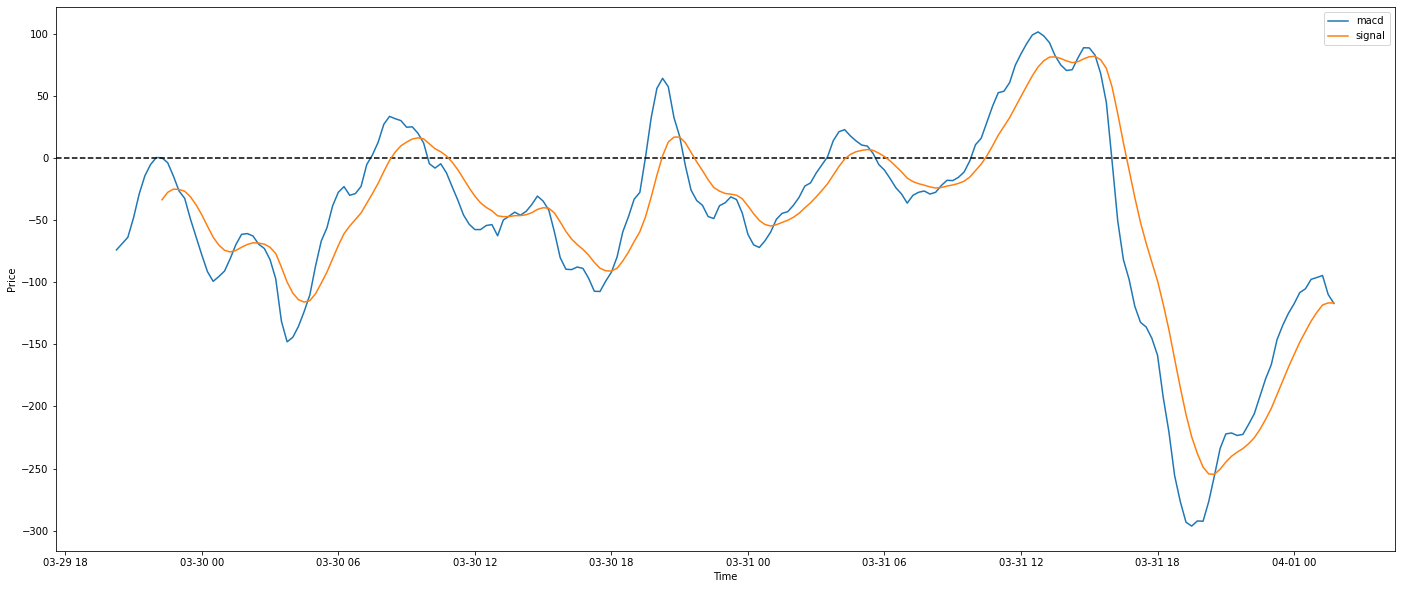

In [25]:
df = getOfflinePrices(interval=Intervals.fifteenMin).tail(240)
macd, macdsignal = get_macd(df.close, fastperiod=12, slowperiod=26, signalperiod=9)
plt.figure(figsize=[24, 10])
plt.xlabel('Time')
plt.ylabel('Price')
plt.plot(macd, label='macd')
# plt.plot(df['close'], label='Closing Prices')
plt.axhline(y=0, color='black', linestyle='--')
plt.plot(macdsignal, label='signal')
# plt.plot(np.arange(250-15, df.shape[0]+1),df2.close.tail(16),label='5min')
plt.legend()
plt.show()
